# Introduction

I completed this project as part of my Advanced Data Science Methods course that I took at the University of Washington.

In this Notebook, we will be working with the Wisconsin Breast Cancer Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). You can download it [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)). 

Via the data set's website description, there are 10 features describing the physical properties of cell nuclei and one for cancer status (malignant or benign).

**Attribute Information:**
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10


11. Class: (2 for benign, 4 for malignant)

**Note:** I am using a slightly different version of the data set where the Class values were encoded like ('M' for malignant, 'B' for benign). This means that we will need to create numerical values for that categorical variable.

In [155]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.formula.api as smf
from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

## EDA

In [2]:
#load the data, drop id column
data = pd.read_csv('wdbc.csv.bz2')
data.drop('id', axis=1, inplace=True)

#create dummy variable for the diagnosis column
#1 for malignant, 0 if not
data['diag'] = np.where(data.diagnosis=='M', 1, 0)

#now drop the diagnosis column, because we have the dummy variable
data.drop('diagnosis', axis=1, inplace=True)

#replace '.' with '_' for easier name typing and accessing
data.columns = data.columns.str.replace('.', '_')
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concpoints_mean,symmetry_mean,fracdim_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concpoints_worst,symmetry_worst,fracdim_worst,diag
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [3]:
#create sumaary table: means, ranges, #missings, correlation between diagnosis and corresponding feature
means = np.mean(data)

ranges = data.apply(lambda x: x.max() - x.min())

missing = data.isnull().sum()

correlation = data.apply(lambda x: x.corr(data.diag))

In [4]:
#create summary table dataframe
sum_table = pd.DataFrame({'mean': means, 'range': ranges, 'missings': missing, 'correlation': correlation})

#sort by low to high correlation
sum_table.sort_values(by=['correlation'], inplace=True)
sum_table.head(31)

,mean,range,missings,correlation
smoothness_se,0.007041,0.029417,0,-0.067016
fracdim_mean,0.062798,0.047480,0,-0.012838
texture_se,1.216853,4.524800,0,-0.008303
symmetry_se,0.020542,0.071068,0,-0.006522
fracdim_se,0.003795,0.028945,0,0.077972
concavity_se,0.031894,0.396000,0,0.253730
compactness_se,0.025478,0.133148,0,0.292999
fracdim_worst,0.083946,0.152460,0,0.323872
symmetry_mean,0.181162,0.198000,0,0.330499
smoothness_mean,0.096360,0.110770,0,0.358560


In [33]:
#now subset variables with high correlation with diagnosis
#get column names for highly correlated variables
high_corr = sum_table[sum_table.correlation > 0.75]

#columns to plot
plot_data = data.loc[:, list(high_corr.index)]

#do the same thing for the low correlation variables
low_corr = sum_table[sum_table.correlation < 0]
plot_data2 = data.loc[:, list(low_corr.index)]

#we need to add the 'diag' column, otherwise we can't use the pairplot() method
#the highly correlated data already includes the 'diag' column
plot_data2['diag'] = plot_data.diag

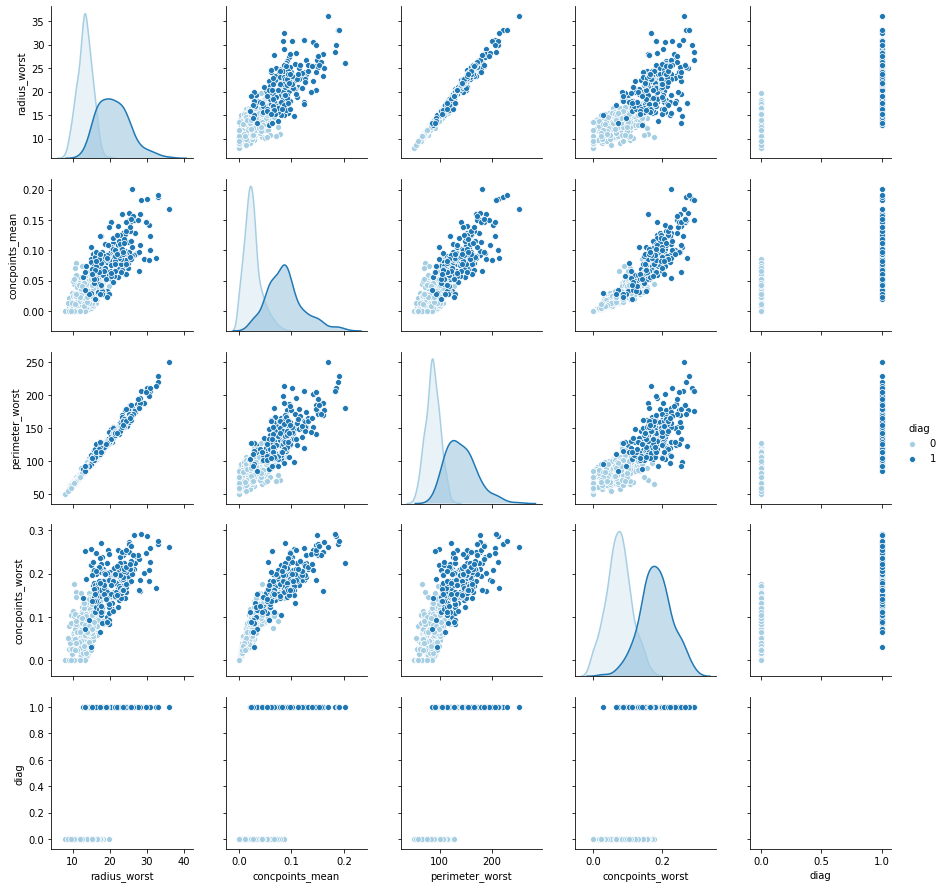

In [34]:
#highly correlated features
sns.pairplot(plot_data, hue='diag', palette='Paired')
plt.show()

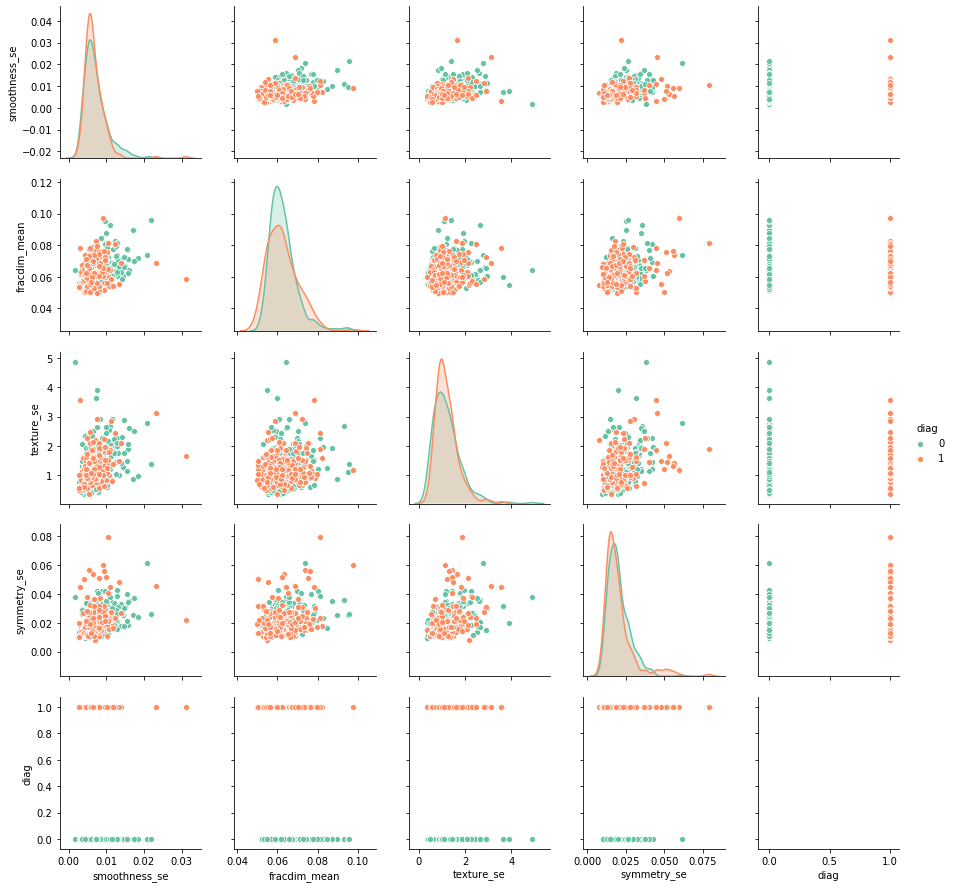

In [35]:
#low correlation features
sns.pairplot(plot_data2, hue='diag', palette='Set2')
plt.show()

The more circular, clustered features are not well correlated with diagnosis. You also notice much more overlap of malignant and non-malignant cell data when the features are not highly correlated with diagnosis, which is illustrated booth by the circular points but also the underlying distributions. This means that we wouldn't be able to separate them very well.

## Drawing Decision Boundaries

We can now draw descision boundaries for a given model. That is, we can plot the predictions not just for the points we are given, but over a range of realistic values that we might encounter with future measurements. For this analysis, we can see how well a KNN model performes compared to a logistic regression classifier.

### kNN

In [36]:
#pick two features, predict on grid
data['radius_worst2'] = data.radius_worst.values/100
X = data[['radius_worst2', 'concpoints_worst']]
y = data.diag

#create models, fit to data
knn = KNeighborsClassifier(n_neighbors=5).fit(X,y)

#create meshgrid to predict on
xx = np.arange(0, 0.4, .004)
yy = np.arange(0, 0.4, .004)
xx_, yy_ = np.meshgrid(xx, yy)

#make predictions
X_star = knn.predict(np.c_[xx_.ravel(), yy_.ravel()])
X_star = X_star.reshape(xx_.shape)

In [37]:
"""
Plot a decision boundary for a given model and grid, overlayed
with the scatter points of the actual data
"""
def plot_decision_boundary(xx_, yy_, grid_preds, X, y, cmap):
    plt.figure(figsize=(8, 8))

    #fill meshgrid with predicitons
    plt.pcolormesh(xx_, yy_, grid_preds, cmap=cmap)

    #scatter actual points
    plt.scatter(X[xlabel], X[ylabel], alpha=0.5, c=y)

    #label x and y axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

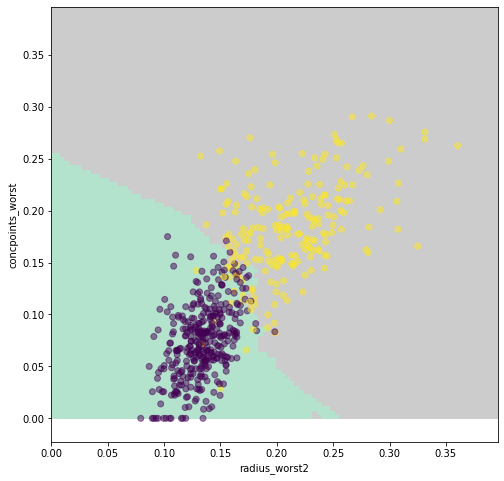

In [38]:
#plot data and decision boundary
cmap = plt.get_cmap('Pastel2')

xlabel, ylabel = 'radius_worst2', 'concpoints_worst'

#visualize data
plot_decision_boundary(xx_, yy_, X_star, X, y, cmap)

_A note on color scheme:_ The green background corresponds to predicted benign, the gray to predicted malignant. The puple dots are actual benign values, the yellow dots actual malign diagnosis.

The KNN classifier does a pretty good job predicting the values and shape of the actual labels. Almost all of the actual benign diagnoses were classified correctly. However, there were quite a few malign diagnoses that were missed. This brings up an important point about intention: in my view, it is more important to minimize the amount of mis-classified malign tumors at the expense of some false-alarms for healthy people. So we will try to design a classifier with that in mind.

### Logistic Regression

In [39]:
#fit logistic classifier with these same two features
logreg = LogisticRegression()
logreg.fit(X, y)

/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
#predict features on similar grid
X_star2 = logreg.predict(np.c_[xx_.ravel(), yy_.ravel()])
X_star2 = X_star2.reshape(xx_.shape)

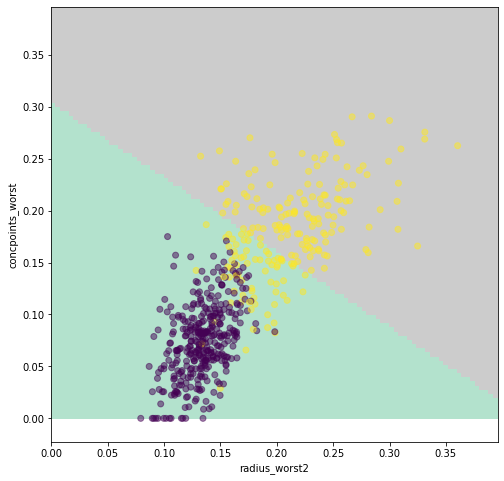

In [41]:
#visualize data for the logistic regression model
plot_decision_boundary(xx_, yy_, X_star2, X, y, cmap)

_A note on color scheme:_ The green background corresponds to predicted benign, the gray to predicted malignant. The puple dots are actual benign values, the yellow dots actual malign diagnosis. <br>

The KNN classifier did a much better job predicting the diagnosis values than did the logistic regressor. The logistic regressor presented a fairly linear plane to fit the data, which did not cut the boundary that well. All of the benign cases were classified correctly, at the cost of many malign cases being misdiagnosed.

While that is the case, it could be interesting to see how well we could make the logistic regression model perform.

### Feature Engineering

In [46]:
#create new features using same two features as above
ex = X.radius_worst2 - 0.05
ex2 = ex**2
log_ex = np.log(ex)

why = X.concpoints_worst
neg_why = -1*why+.1
why2 = why**1.5
why2_5 = why2 - 0.05

In [48]:
#fit log_reg classifier
X_new = pd.DataFrame({'ex':ex, 'ex2':ex2, 'log_ex':log_ex, 'why':why,
                      'why2':why2, 'neg_why':neg_why, 'why2_5':why2_5})
y_new = data.diag
first_try = X_new[['ex', 'why2']]

logreg2 = LogisticRegression(solver='lbfgs', tol=1e-12)
logreg2.fit(first_try, y_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-12, verbose=0,
                   warm_start=False)

In [49]:
#create decision boundary plot
first_try_pred = logreg2.predict(np.c_[xx_.ravel(), yy_.ravel()])
first_try_pred = first_try_pred.reshape(xx_.shape)

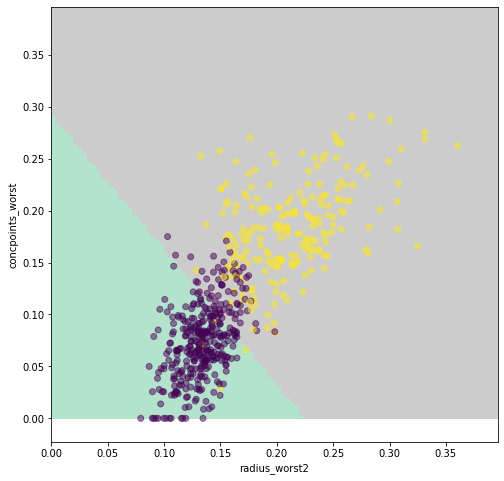

In [50]:
#visualize data for the logistic regression model
plot_decision_boundary(xx_, yy_, first_try_pred, X, y, cmap)

I have attempted to engineer some features so that I could get the best decision boundary for the logistic classifier as possible. I ended up using `ex`, which was the value of `radius_worst` scaled to match the dimensions of `concpoints_worst`, and `why2`, which is actually the dimensions of `concpoints_worst` raised to the (3/2) power. I ended up going with this set of features because it was the boundary that minimized the amount of false positives. I felt this was important giving the data we were working with: it would be bad to misclassify a tumor as benign when it is actually malignant. The tradeoff was that there were quite a few misdiagnosed benign tumors. Again, I fel justified in doing this because it would be better to have to go in for further testing (especially if you have a tumor whose dimensions lie close to the boundary line given), than to miss a diagnosis for the worse.

With further data exploration, I believe that other features (not the x and y I originally picked) could be found that better predict the tumor diagnosis if I wanted to use a logistic regression classifier. In my case, concpoints_worst had a lot higher spread than radius_worst, which cause a significant amount of overlap and made it hard to fit a decision boundary to the data. However, as seen above, classifiers like knn worked well given only these two features.

Additionally, I think that it is worth noting that at this point, no significant regularization or cross-validation has been done to help the logistic classifier. This, I think, would improve results for the logistic classifier.

### Cross Validation

Here, I will show how we can implement a version of k-fold cross-validation ourselves. There is a method in sklearn that will do it for you, but it is always good to know how something you are using is working.


#### Some helper methods

In [86]:
"""
This method allows us to input shuffled indices and a number of folds k,
and then perform cross-validation ourselves. We need to pass the method the dataframe
containing the features, arrays to store metrics, and a model that we want to use for prediction.
"""
def kfold_crossval(acc, prec, rec, idx, k, df, model):
    for i in range(k):
        # i::k means go from index, to the end, up by k units at a time
        itest = indices[i::k]
        itrain = list(set(indices).difference(itest))

        #create training and test sets
        testDat = df.iloc[itest]
        X_test = testDat.drop('diag', axis=1)
        y_test = testDat.diag

        trainDat = df.iloc[itrain]
        X_train = trainDat.drop('diag', axis=1)
        y_train = trainDat.diag

        #fit and predict on data
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        #calculate metrics, save to arrays
        acc[i] = accuracy_score(y_test, pred)
        prec[i] = precision_score(y_test, pred)
        rec[i] = recall_score(y_test, pred)
        
    return acc, prec, rec

In [87]:
"""
This method allows us to display the average for a number of metrics
across some number of k data splits. The method expects an array containing
accuracy, precision, and recall scores.
"""
def print_metrics(acc, prec, rec):
    #take mean of different metrics
    acc_mean = accuracy.mean()
    pres_mean = precision.mean()
    rec_mean = recall.mean()

    #create dataframe for easy displaying
    means = pd.DataFrame({'accuracy':acc_mean, 'precision': pres_mean, 'recall': rec_mean}, index=['means'])
    
    print(means)

In [81]:
#k-fold cross-validation with k=10
k = 10
indices = np.arange(len(data))
np.random.shuffle(indices)

#fit all training data on LogisticRegression() classifier, predict on testing data
accuracy = np.empty(k)
precision = np.empty(k)
recall = np.empty(k)

log_reg = LogisticRegression(solver='liblinear')

accuracy, precision, recall = kfold_crossval(accuracy, precision, recall, indices, k, data, log_reg)

In [82]:
#report average accuarcy, precision, and recall across all runs
print_metrics(accuracy, precision, recall)

       accuracy  precision   recall
means  0.952569   0.947402  0.92472


### Regularization

For our regularization analysis, we can do something similar. But this time, we will need to train a RidgeClassifier() with different alpha values for different regularization strengths (here my alpha values are in the `lambdas` list).

In [255]:
"""
This method allows us to input shuffled indices and a number of folds k,
and then perform cross-validation ourselves. We need to pass the method the X and y arrays for
the features and target variables, arrays to store metrics, and a list of lambda values.
The ridge regression model will be built with every value of lambda within the method.
"""
def kfold_crossval_regularization(acc, prec, rec, lambdas, k, indices, df):
    #create data splits
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    skf.get_n_splits(X, y)
        
    #loop over lambda values
    for j in lambdas:
        
        #create ridge regression model
        model = RidgeClassifier(alpha=j)

        for i in range(k):
        # i::k means go from index, to the end, up by k units at a time
            itest = indices[i::k]
            itrain = list(set(indices).difference(itest))

            #create training and test sets
            testDat = df.iloc[itest]
            X_test = testDat.drop('diag', axis=1)
            y_test = testDat.diag

            trainDat = df.iloc[itrain]
            X_train = trainDat.drop('diag', axis=1)
            y_train = trainDat.diag
        
            #fit and predict on data
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            #calculate metrics, save to arrays
            acc[i] = accuracy_score(y_test, pred)
            prec[i] = precision_score(y_test, pred)
            rec[i] = recall_score(y_test, pred)
        
    return acc, prec, rec

In [256]:
#k-fold cross-validation with k=10
k = 10
indices = np.arange(len(data))
np.random.shuffle(indices)

#pick wide range of regularization parameters
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
length = len(lambdas)

#create arrays to save metrics to
accuracy2 = np.empty(length)
precision2 = np.empty(length)
recall2 = np.empty(length)

#create feature and target arrays
X = data.drop('diag', axis=1)
y = data.diag

skf = StratifiedKFold(n_splits=k, shuffle=True)
skf.get_n_splits(X, y)

accuracy2, precision2, recall2 = kfold_crossval_regularization(accuracy2, precision2, recall2, lambdas, k, indices, data)

In [257]:
"""
This method plots accuracy, precision, and recall across k-fold splits
of training for different regularization values of lambda.
"""
def plot_metrics(lambdas, acc, pre, rec):
    #plot accuracy scores across lambda values
    plt.plot(lambdas, acc, label='accuracy', color='green')
    plt.xscale('log')
    
    #plot precision scores across lambda values
    plt.plot(lambdas, pre, label='precision', color='red')
    plt.xscale('log')

    #plot recall scores across lambda values
    plt.plot(lambdas, rec, label='recall', color='blue')
    plt.xscale('log')

    #add legend, show plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [258]:
"""
Similar to the print_metrics(), method, but instead we print out the average metrics
for k-folds and some number j of lambda values used in regularization.
"""
def print_metrics_regularized(lambdas, acc, prec, rec):
    #create a dataframe for easy printing
    metrics = pd.DataFrame({'accuracy':acc, 'precision':prec, 'recall':rec}, index=lambdas)
    metrics.index.name = 'lambda'

    print(metrics)

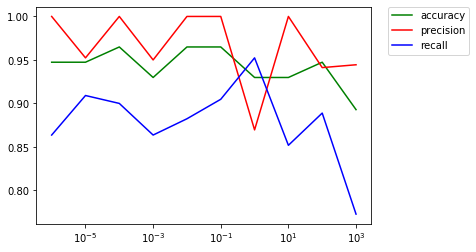

In [259]:
#report results: graph, table
plot_metrics(lambdas, accuracy2, precision2, recall2)

In [260]:
#create list of strings for lambda values
str_lambdas = ['1e-6','1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1e0', '1e1', '1e2', '1e3']

#display scores
print_metrics_regularized(str_lambdas, accuracy2, precision2, recall2)

        accuracy  precision    recall
lambda                               
1e-6    0.947368   1.000000  0.863636
1e-5    0.947368   0.952381  0.909091
1e-4    0.964912   1.000000  0.900000
1e-3    0.929825   0.950000  0.863636
1e-2    0.964912   1.000000  0.882353
1e-1    0.964912   1.000000  0.904762
1e0     0.929825   0.869565  0.952381
1e1     0.929825   1.000000  0.851852
1e2     0.947368   0.941176  0.888889
1e3     0.892857   0.944444  0.772727


The lambda value that maximizes recall is 1. This is not the value that maximizes accuracy or recall, but again we want to minimize False Negatives. This [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall) page has a good explanation of precision vs recall, and accuracy is not the most telling metric for our purposes. However, we can analyze it below to get a sense of how different models are performing.

## ROC Curve

In [262]:
#split testing/training data, use 0.3 test_size
X_ = data.drop('diag', axis=1)
y_ = data.diag
X_tr, X_te, y_tr, y_te = train_test_split(X_, y_, test_size=0.3)


#create set of scaled data for knn classifier
scaler = StandardScaler()

#create copy of features
X2 = X_
#scale data
X_scaled = scaler.fit_transform(X2)
#create data frame of scaled features with column names for easy accessing
X_scaled2 = pd.DataFrame(X_scaled, index=X_.index, columns=X_.columns)

#get target variable
y2 = data.diag
#split data
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_scaled2, y2, test_size=0.3)

In [263]:
#using training data, train a few different models
knn = KNeighborsClassifier(n_neighbors=6)
nb = GaussianNB()

#C is the inverse of our regularization parameter: 1/(1e0) = 1
lr = LogisticRegression(C=1, solver='liblinear')

#predict probabilities
#knn expects normalized features
knn.fit(X_tr2, y_tr2)
pred_knn = knn.predict(X_te2)

nb.fit(X_tr, y_tr)
pred_nb = nb.predict_proba(X_te)

lr.fit(X_tr, y_tr)
pred_lr = lr.predict_proba(X_te)

In [267]:
def plot_roc(fp, tp, color, label):
    #create plot and middle line
    plt.plot([0, 1], [0, 1], 'k--')
    
    #plot ROC curve
    plt.plot(fp, tp, color, label=label)

    #add x and y lables
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    #add title and legend, show plot
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

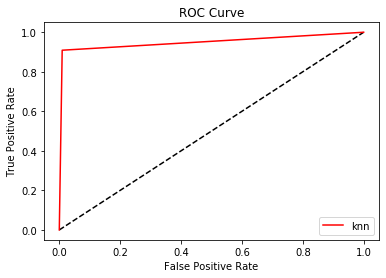

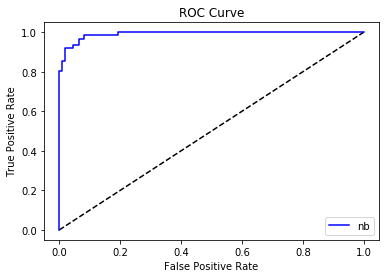

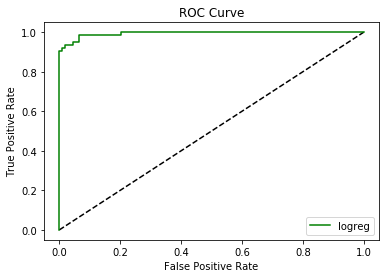

In [268]:
#predict probabilities, thresholds will be set during plotting
fp_knn, tp_knn, thresh_knn = roc_curve(y_te2, pred_knn)
fp_nb, tp_nb, thresh_nb = roc_curve(y_te, pred_nb[:, 1])
fp_lr, tp_lr, thresh_lr = roc_curve(y_te, pred_lr[:, 1])

#plot roc curve for knn model
plot_roc(fp_knn, tp_knn, 'r', 'knn')

#plot roc curve for naive bayes model
plot_roc(fp_nb, tp_nb, 'b', 'nb')

#plot roc curve for logistric regression model
plot_roc(fp_lr, tp_lr, 'g', 'logreg')

The best results for accuracy were shown by the logistic regression classifier, shown in green. It best approximates the data, where a great classifier has a vertical line from the x axis at 0, and a horizontal line on the y axis at 1 (we are trying to fit our classifier to the top left corner on the ROC curve). The model that does this is the logistic regression classifier using the optimal regularization parameter we found using ridge regression.

However, as discussed above, we should instead be focusing instead on metrics like recall and f-beta score. This is because we want to minimize the number of False Positives we are outputting. In that sense, I would use a KNN model so that our prediction space is not planar like that of the logistic regressor. Then I would focus on tuning the model so that a minimal amount of malign tumors were mis-diagnosed as benign, at the cost of false alarms for some bening tumors.